### Impact Predict

Le but du projet est de créer une métrique qui met en avant les 5 joueurs les plus impactant par position des 5 grands championnats (Premier League, La Liga, Serie A, Bundesliga, Ligue 1) ayant un impact monstre ou prépondérant sur les résultats de leurs équipes. Ensuite, il faut aussi créer des radar charts pour le top 10.

La première étape consiste donc à classer les joueurs par poste. Les données comportent une colonne « Position », mais les entrées peuvent varier (comme « Attaquant », « Milieu de terrain », « Défenseur »). Je vais devoir les standardiser en trois groupes : « Attaquant », « Milieu », « Défenseur ». Peut-être que certains joueurs ont plusieurs positions, mais pour plus de simplicité, je prendrai la position principale répertoriée.

Ensuite, pour chaque position, je dois définir des métriques pertinentes. Les attaquants doivent être davantage jugés sur les buts, les passes décisives, les xG, etc. Les milieux de terrain peuvent avoir besoin d'un équilibre entre les statistiques offensives et défensives. Les défenseurs se concentreraient sur les tacles, les interceptions, les dégagements, etc. Le code d'origine utilisait un ensemble de statistiques, mais je dois maintenant les ajuster en fonction de la position.

Je vais devoir créer trois ensembles distincts de colonnes et de pondérations. Par exemple, les attaquants peuvent avoir des pondérations plus élevées sur « Buts + Passes décisives par 90 » et « xG + xAG par 90 », tandis que les défenseurs ont des pondérations plus élevées sur « Tacles réussis par 90 » et « Interceptions par 90 ». Les milieux de terrain peuvent avoir un mélange des deux.

Ensuite, la normalisation doit être effectuée au sein de chaque groupe de positions. Ceci est important car les statistiques varient selon la position ; le nombre de plaquages ​​d'un défenseur est naturellement plus élevé que celui d'un attaquant. En normalisant au sein des groupes, nous garantissons une comparaison équitable.

Après avoir calculé le SIG pour chaque position, je les classerai et sélectionnerai les 5 meilleurs pour chacun. De plus, la génération de graphiques radar pour les 10 meilleurs de toutes les positions aiderait à visualiser leurs points forts. L'utilisation d'une bibliothèque comme matplotlib ou seaborn en Python peut aider à tracer ces graphiques radar. Chaque graphique affichera les statistiques normalisées pour les métriques sélectionnées.

Problèmes potentiels à prendre en compte : gérer les données manquantes, s'assurer que toutes les colonnes requises sont présentes et mapper correctement les positions. De plus, certains joueurs peuvent être répertoriés sous des noms de poste différents (par exemple, « Attaquant » contre « Attaquant »), il est donc essentiel de normaliser ces étiquettes.

Tester le code avec des exemples de données aidera à vérifier si les calculs SIG ont du sens par poste. Par exemple, un défenseur de haut niveau doit avoir des statistiques défensives élevées, tandis qu'un attaquant de haut niveau excelle dans les mesures offensives. Il peut être nécessaire d'ajuster les pondérations si les résultats initiaux ne reflètent pas les classements attendus.

Enfin, le code doit afficher les 5 meilleurs joueurs par poste et générer des graphiques radar, en les enregistrant sous forme d'images pour une référence facile. L'utilisateur peut ensuite analyser la manière dont les contributions de chaque joueur se comparent à celles des autres à leur poste.

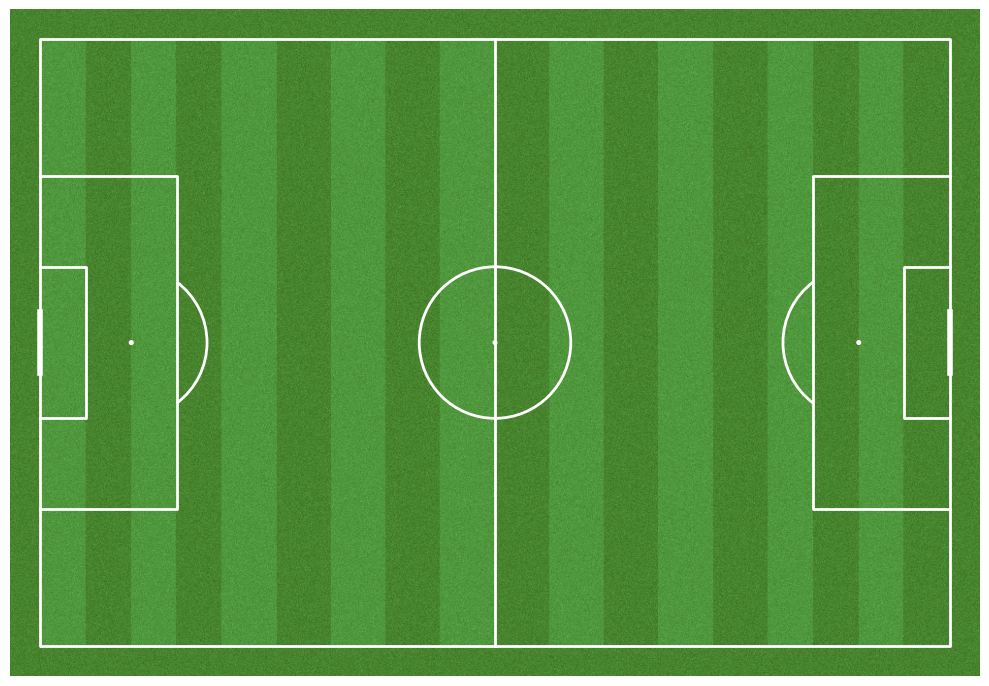

In [1]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

pitch = Pitch(line_color='white', pitch_type='statsbomb', pitch_color='grass', stripe=True)
fig, ax = pitch.draw(figsize=(10, 7))

plt.show()



In [2]:
import pandas as pd
import numpy as np 
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


### Import data of all players from the 5 Greatest Championship

In [3]:
df = pd.read_csv('df_Big5.csv')
df = df[df['Pourcentage de minutes jouees'] > 60]
df.head()

,Index,Joueur,Age,Position,Ligue,Equipe,Matchs joues,Titularisations,Minutes jouees,Matches equivalents 90 minutes,...,Dribbles reussis,Pourcentage de dribbles reussis,Ballons perdus apres dribble,Pourcentage de ballons perdus apres dribble,Portees de balle,Distance totale parcourue avec le ballon,Distance progressive parcourue avec le ballon,Courses progressives.1,Courses vers le dernier tiers,Courses dans la surface adverse
4,4,Yunis Abdelhamid,35.0,Defender,Ligue 1,Reims,31.0,31.0,2781.0,30.9,...,8.0,53.3,7.0,46.7,1506.0,8663.0,4921.0,36.0,19.0,0.0
7,7,Laurent Abergel,30.0,Midfielder,Ligue 1,Lorient,33.0,32.0,2860.0,31.8,...,44.0,67.7,18.0,27.7,1649.0,8707.0,3892.0,38.0,49.0,3.0
11,11,Abdel Abqar,24.0,Defender,La Liga,Alavés,27.0,27.0,2312.0,25.7,...,3.0,60.0,1.0,20.0,492.0,2460.0,1418.0,7.0,6.0,0.0
13,13,Francesco Acerbi,35.0,Defender,Serie A,Inter,29.0,26.0,2388.0,26.5,...,2.0,66.7,1.0,33.3,1211.0,5779.0,3081.0,21.0,11.0,0.0
16,16,Akor Adams,23.0,Forward,Ligue 1,Montpellier,32.0,27.0,2252.0,25.0,...,14.0,31.8,26.0,59.1,442.0,2673.0,1004.0,40.0,23.0,22.0


In [4]:
df.shape

(729, 150)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 4 to 2844
Columns: 150 entries, Index to Courses dans la surface adverse
dtypes: float64(145), int64(1), object(4)
memory usage: 860.0+ KB


In [6]:
df.describe()

,Index,Age,Matchs joues,Titularisations,Minutes jouees,Matches equivalents 90 minutes,Buts,Passes decisives,Buts + Passes decisives,Buts hors penalty,...,Dribbles reussis,Pourcentage de dribbles reussis,Ballons perdus apres dribble,Pourcentage de ballons perdus apres dribble,Portees de balle,Distance totale parcourue avec le ballon,Distance progressive parcourue avec le ballon,Courses progressives.1,Courses vers le dernier tiers,Courses dans la surface adverse
count,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,...,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,1460.840878,26.305898,31.794239,29.013717,2533.847737,28.155693,3.587106,2.530864,6.117970,3.165981,...,18.314129,49.237860,16.816187,36.082579,937.710562,4996.781893,2532.784636,40.341564,31.318244,9.997257
std,825.332305,3.934349,3.599286,4.306885,382.750277,4.252268,4.858537,2.766945,6.703273,4.210289,...,18.091460,21.977485,17.916525,19.066626,368.328590,2031.377818,1172.617366,34.968313,24.384967,15.266407
min,4.000000,16.000000,21.000000,20.000000,1838.000000,20.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,269.000000,946.000000,340.000000,0.000000,0.000000,0.000000
25%,748.000000,23.000000,29.000000,25.000000,2212.000000,24.600000,0.000000,0.000000,1.000000,0.000000,...,5.000000,39.700000,3.000000,25.500000,666.000000,3511.000000,1717.000000,15.000000,12.000000,1.000000
50%,1453.000000,26.000000,32.000000,29.000000,2511.000000,27.900000,2.000000,2.000000,4.000000,2.000000,...,14.000000,50.000000,12.000000,40.000000,875.000000,4688.000000,2373.000000,32.000000,27.000000,4.000000
75%,2218.000000,29.000000,34.000000,32.000000,2791.000000,31.000000,5.000000,4.000000,9.000000,4.000000,...,25.000000,59.300000,24.000000,50.000000,1139.000000,6160.000000,3160.000000,58.000000,47.000000,13.000000
max,2844.000000,39.000000,38.000000,38.000000,3420.000000,38.000000,36.000000,14.000000,44.000000,31.000000,...,124.000000,100.000000,101.000000,100.000000,2513.000000,12006.000000,6693.000000,184.000000,133.000000,102.000000


# Clean data
1. Suppression des doublons (s'il y en avait)
2. Gestion des valeurs manquantes (si existante)


In [7]:
df.duplicated().sum()

0

In [8]:
df.duplicated().sum()

0

In [9]:
df.isna().sum()

Index                                            0
Joueur                                           0
Age                                              0
Position                                         0
Ligue                                            0
                                                ..
Distance totale parcourue avec le ballon         0
Distance progressive parcourue avec le ballon    0
Courses progressives.1                           0
Courses vers le dernier tiers                    0
Courses dans la surface adverse                  0
Length: 150, dtype: int64

In [10]:
df.columns.tolist()

['Index',
 'Joueur',
 'Age',
 'Position',
 'Ligue',
 'Equipe',
 'Matchs joues',
 'Titularisations',
 'Minutes jouees',
 'Matches equivalents 90 minutes',
 'Buts',
 'Passes decisives',
 'Buts + Passes decisives',
 'Buts hors penalty',
 'Penalty marques',
 'Penalty tentes',
 'Cartons jaunes',
 'Cartons rouges',
 'Buts attendus (xG)',
 'Buts attendus hors penalty (npxG)',
 'Passes decisives attendues (xAG)',
 'xG + xAG hors penalty',
 'Passes progressives',
 'Courses progressives',
 'Receptions progressives',
 'Buts par 90 minutes',
 'Passes decisives par 90 minutes',
 'Buts + Passes decisives par 90 minutes',
 'Buts hors penalty par 90 minutes',
 'Buts + Passes decisives hors penalty par 90 min',
 'xG par 90 minutes',
 'xAG par 90 minutes',
 'xG + xAG par 90 minutes',
 'npxG par 90 minutes',
 'npxG + xAG par 90 minutes',
 'Actions menant a un tir',
 'Actions menant a un tir par 90 minutes',
 'Passes vivantes menant a un tir',
 'Passes arretees menant a un tir',
 'Ballons perdus menant a 

In [11]:
# Nettoyer les positions
df['Position'] = df['Position'].replace({
    'Forward': 'Attaquant',
    'Midfielder': 'Milieu',
    'Defender': 'Defenseur'
    })

In [12]:
# Filtrer les 5 grands championnats et positions pertinentes
ligues = ["Premier League", "La Liga", "Serie A", "Bundesliga", "Ligue 1"]
df = df[(df["Ligue"].isin(ligues)) & (df['Position'] != 'Gardien')]

# Creation du modele


In [13]:
# Calculer les stats par 90 minutes
def calc_90(col, minutes):
    return (col / minutes) * 90

df['Tacles réussis par 90'] = calc_90(df['Tacles reussis'], df['Minutes jouees'])
df['Interceptions par 90'] = calc_90(df['Interceptions'], df['Minutes jouees'])
df['Duels aériens gagnés par 90'] = calc_90(df['Duels aeriens gagnes'], df['Minutes jouees'])
df['Courses progressives par 90'] = calc_90(df['Courses progressives'], df['Minutes jouees'])
df['Passes progressives par 90'] = calc_90(df['Passes progressives'], df['Minutes jouees'])


# Définir les métriques et pondérations par position
position_metrics = {
    'Attaquant': {
        'metrics': [
            'Buts par 90 minutes',
            'Buts + Passes decisives par 90 minutes', 
            'xG + xAG par 90 minutes',
            'Courses progressives par 90',
            'Dribbles reussis'
        ],
        'weights': [0.3, 0.3, 0.2, 0.1, 0.1]
    },
    'Milieu': {
        'metrics': [
            'Passes decisives par 90 minutes',
            'Passes progressives par 90',
            'Tacles réussis par 90',
            'Interceptions par 90',
            'xG + xAG par 90 minutes'
        ],
        'weights': [0.25, 0.25, 0.2, 0.2, 0.1]
    },
    'Defenseur': {
        'metrics': [
            'Tacles réussis par 90',
            'Interceptions par 90',
            'Duels aériens gagnés par 90',
            'Passes progressives par 90',
            'Ballons recuperes'
        ],
        'weights': [0.3, 0.3, 0.2, 0.1, 0.1]
    }
}


In [14]:
# Fonction pour calculer SIG par position
def calculate_sig_by_position(df, position):
    pos_df = df[df['Position'] == position].copy()
    metrics = position_metrics[position]['metrics']
    weights = position_metrics[position]['weights']
    
    # Normalisation
    scaler = StandardScaler()
    pos_df[metrics] = scaler.fit_transform(pos_df[metrics])
    
    # Calcul SIG
    pos_df['SIG'] = pos_df[metrics].dot(weights)
    return pos_df.sort_values('SIG', ascending=False)

# Calcul pour chaque position
attackers = calculate_sig_by_position(df, 'Attaquant')
midfielders = calculate_sig_by_position(df, 'Milieu')
defenders = calculate_sig_by_position(df, 'Defenseur')

# Afficher les Top 5 par position
def display_top5(pos_df, position_name):
    print(f"\n🔝 Top 5 {position_name} 🔝")
    display(pos_df.head(5)[['Joueur', 'Equipe', 'SIG']])

display_top5(attackers, "Attaquants")
display_top5(midfielders, "Milieux")
display_top5(defenders, "Défenseurs")




🔝 Top 5 Attaquants 🔝


,Joueur,Equipe,SIG
1687,Kylian Mbappé,Paris S-G,2.845501
1293,Harry Kane,Bayern Munich,2.589354
1060,Serhou Guirassy,Stuttgart,2.289758
2021,Cole Palmer,Chelsea,2.005907
1077,Erling Haaland,Manchester City,1.824340



🔝 Top 5 Milieux 🔝


,Joueur,Equipe,SIG
2772,Florian Wirtz,Leverkusen,1.481103
2435,Xavi Simons,RB Leipzig,1.362037
2423,Bernardo Silva,Manchester City,1.133696
2492,Anton Stach,Hoffenheim,1.129044
180,Alex Baena,Villarreal,1.127411



🔝 Top 5 Défenseurs 🔝


,Joueur,Equipe,SIG
292,Bernardo,Bochum,1.771526
1776,Maximilian Mittelstädt,Stuttgart,1.694187
198,Leonardo Balerdi,Marseille,1.622252
2240,Antonee Robinson,Fulham,1.576808
1159,Timo Hübers,Köln,1.567102


### Radar Chart

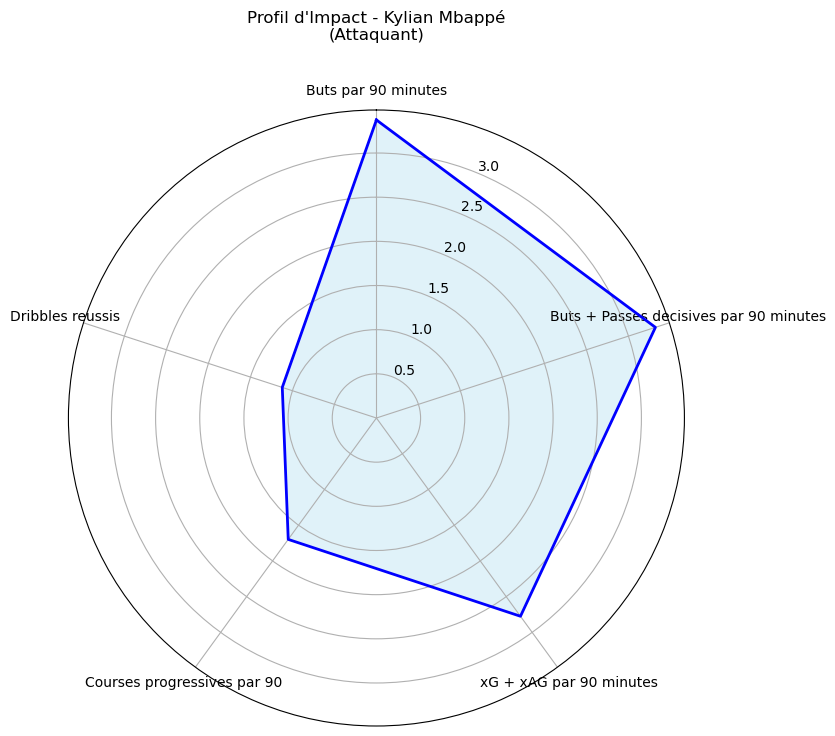

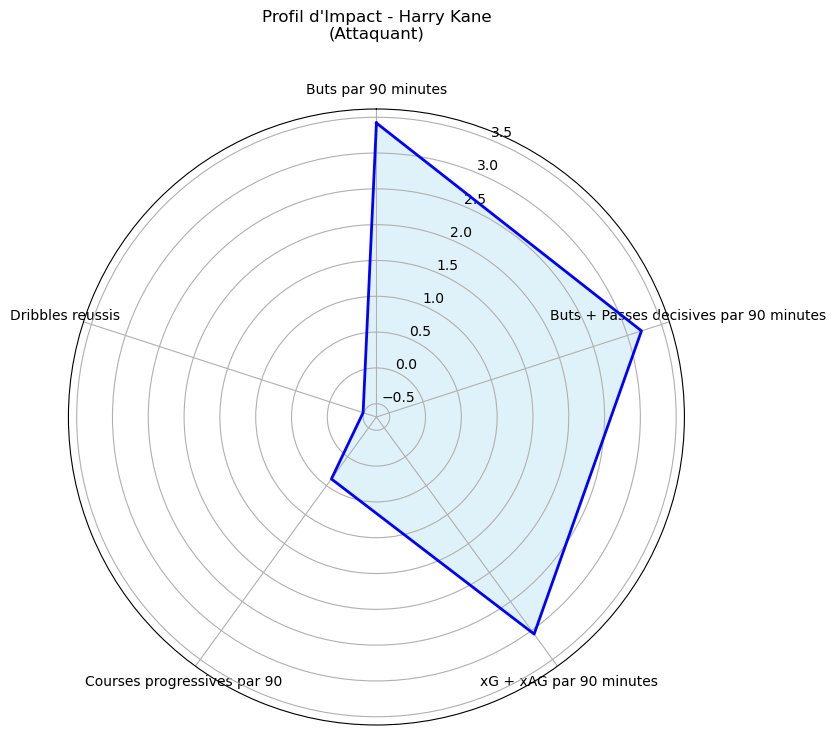

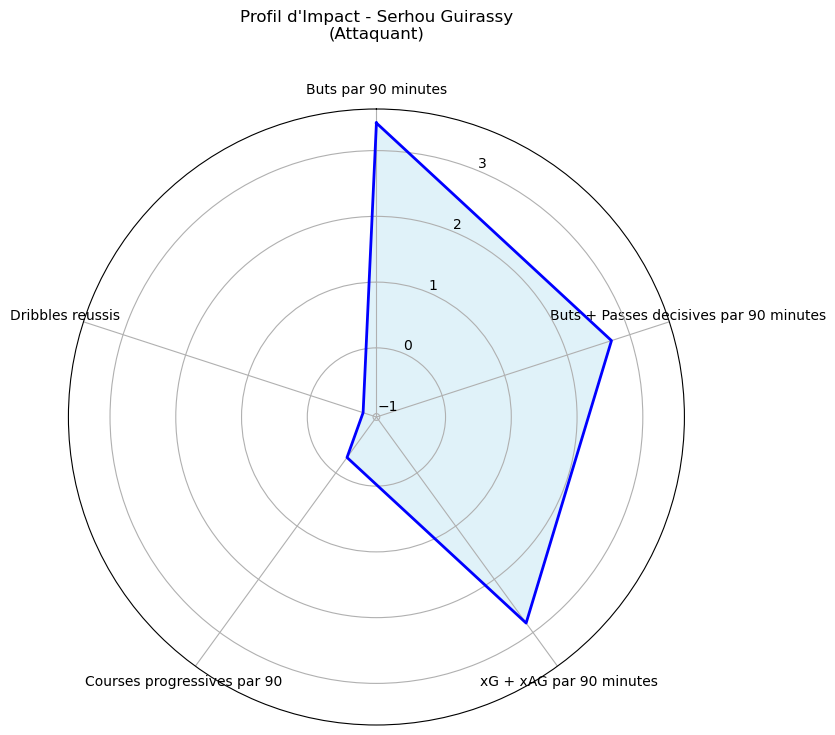

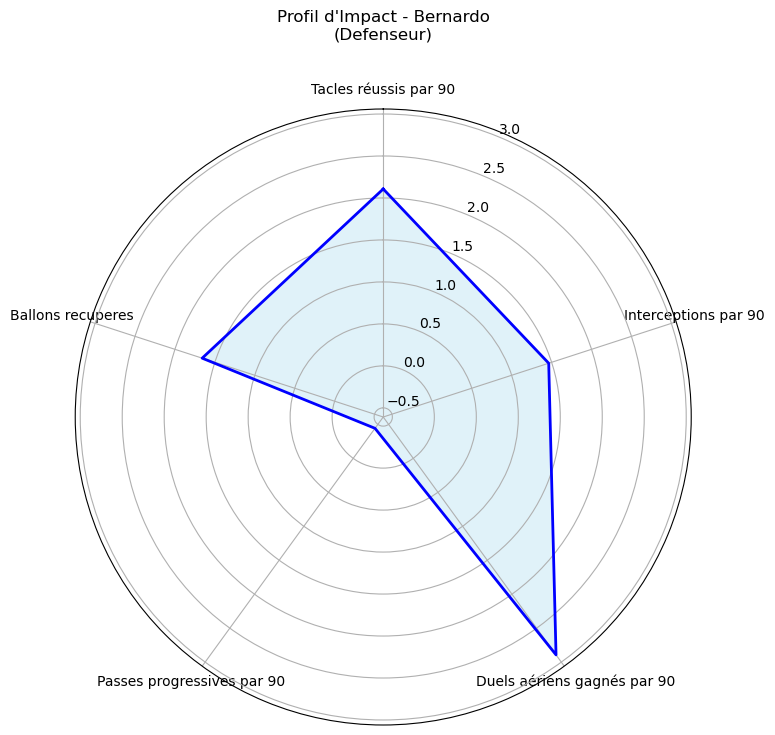

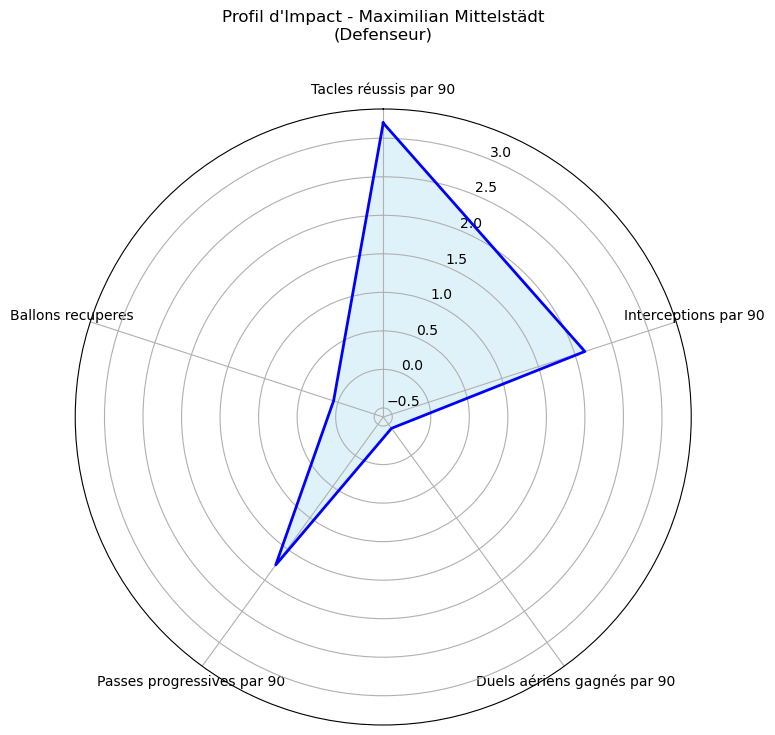

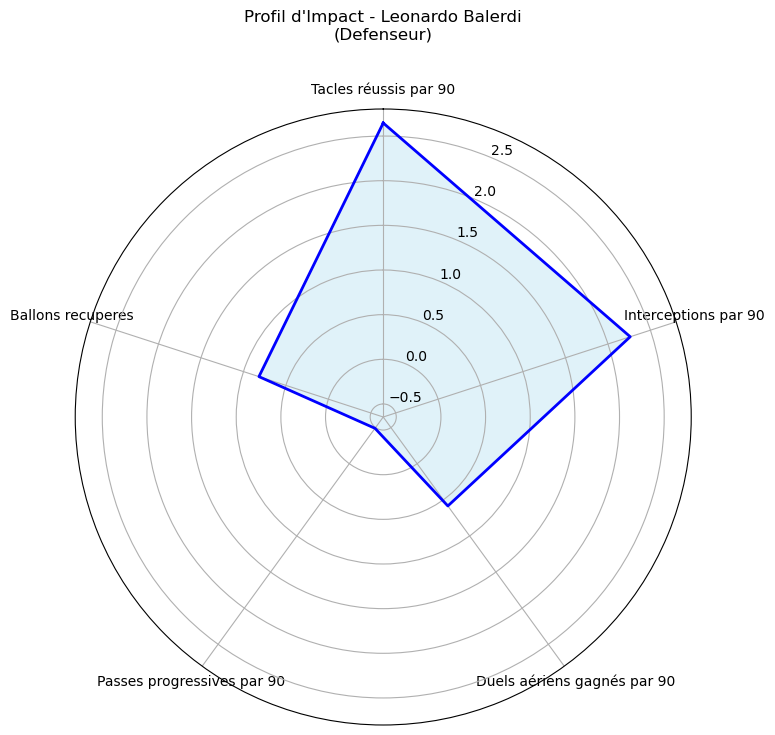

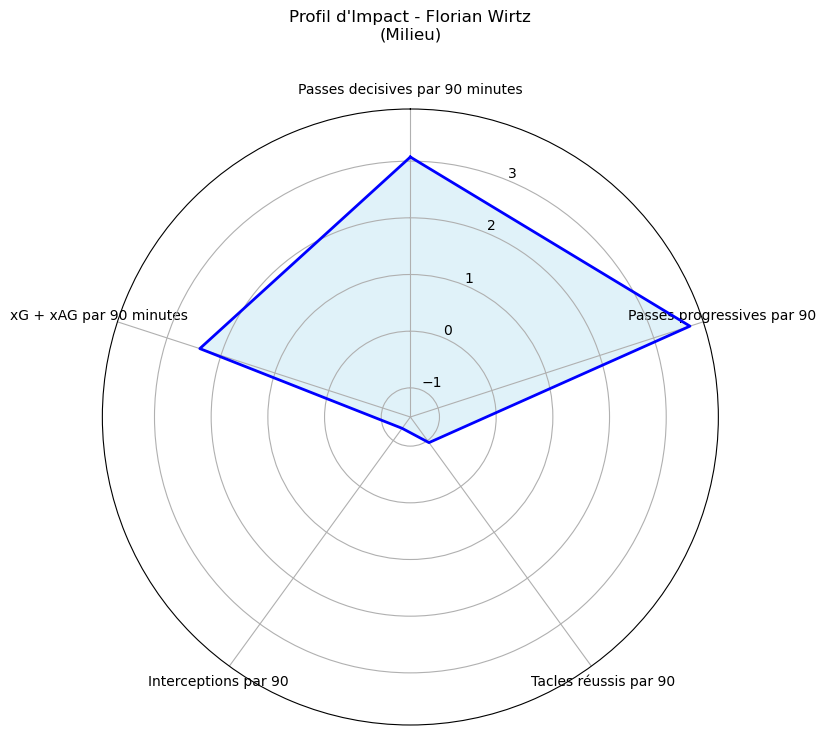

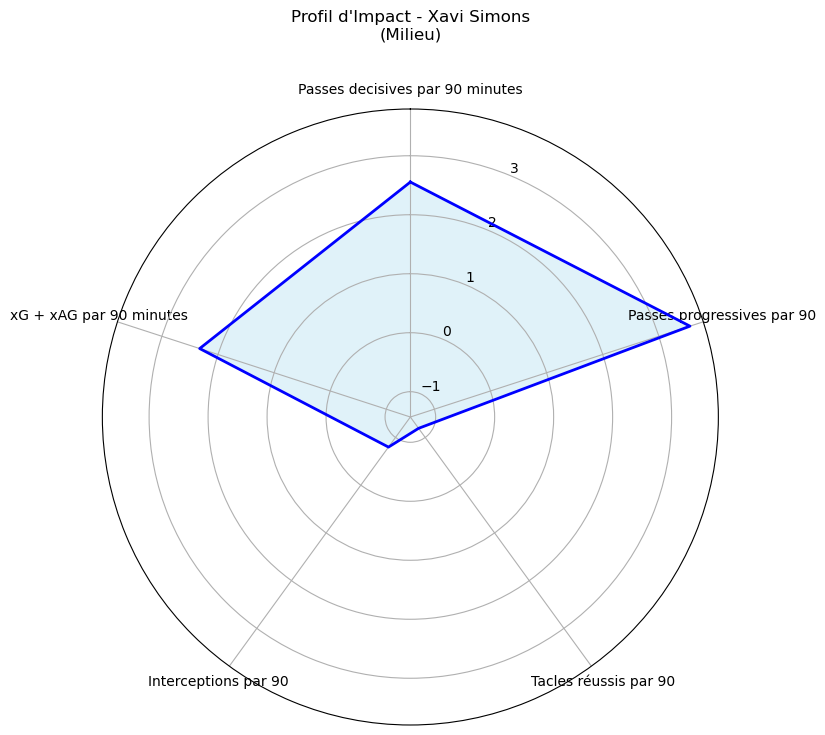

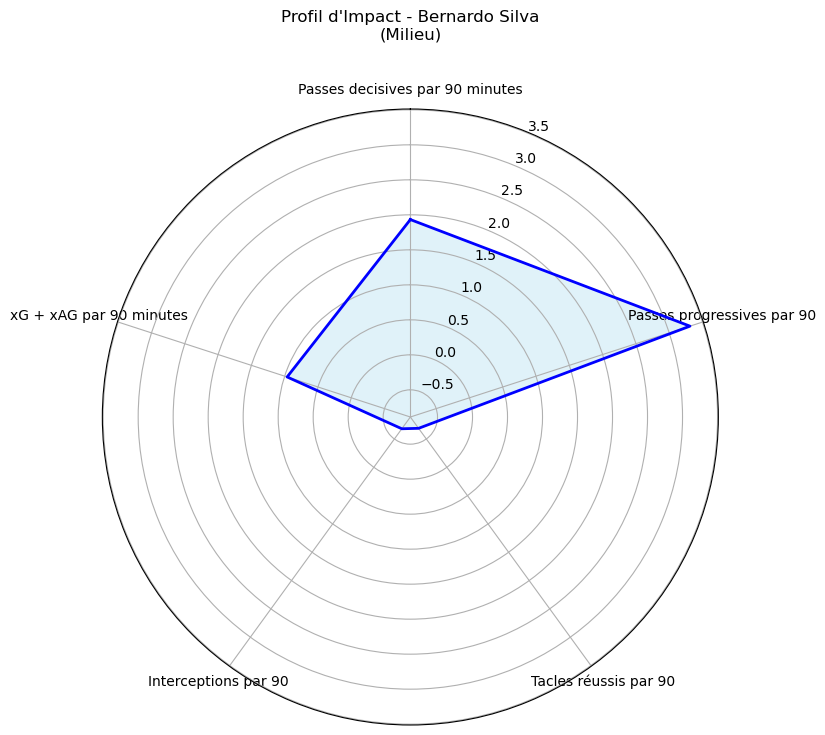

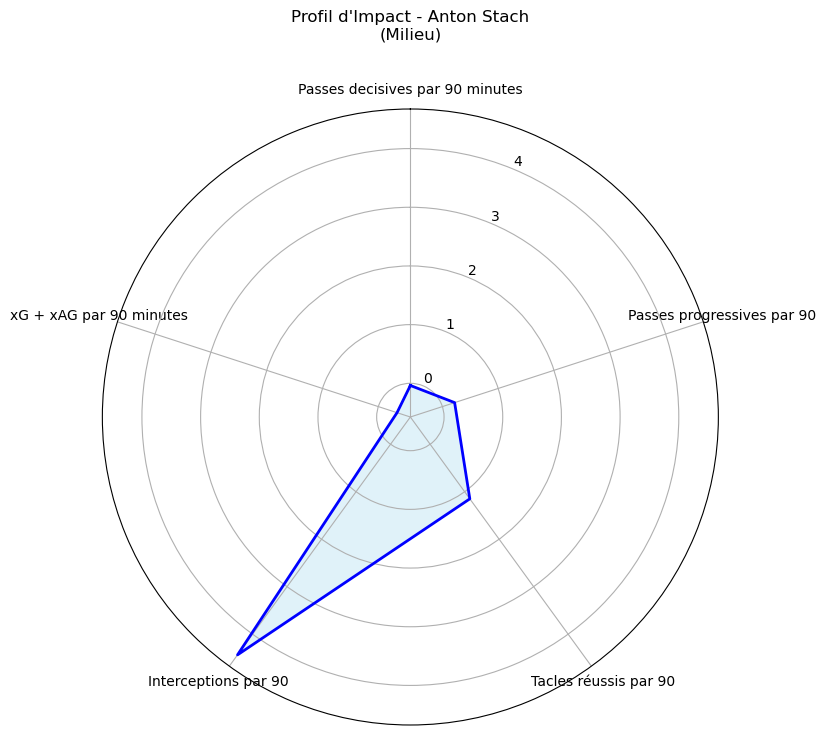

In [15]:
# Génération des Radar Charts
def plot_radar_chart(player_data, position):
    metrics = position_metrics[position]['metrics']
    values = player_data[metrics].values.tolist()
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
    ax.fill(angles, values, color='skyblue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    plt.title(f"Profil d'Impact - {player_data['Joueur']}\n({position})", y=1.1)
    plt.show()

# Exemple pour le top 10 global
top_10_global = pd.concat([attackers.head(3), midfielders.head(4), defenders.head(3)]).sort_values('SIG', ascending=False)

for _, row in top_10_global.iterrows():
    plot_radar_chart(row, row['Position'])  

In [ ]:
import matplotlib.pyplot as plt
from mplsoccer import Radar

# Sélection des 10 meilleurs joueurs par score d'impact
top_10 = forwards.head(10)

# Colonnes à afficher sur les radar charts
columns = [
    'Buts', 'Passes decisives', 'Buts attendus (xG)', 'Passes decisives attendues (xAG)',
    'Tirs', 'Tirs cadres', 'Courses progressives', 'Passes dans la surface adverse'
]

# Définir les limites pour chaque métrique (ici, ajustées en fonction des valeurs maximales de chaque colonne)
min_max = [(0, 30), (0, 20), (0, 1.5), (0, 1.5), (0, 20), (0, 10), (0, 10), (0, 10)]

# Création du radar avec les paramètres nécessaires
params = columns  # Les labels des axes
min_range = [0] * len(columns)  # Les valeurs minimales de chaque métrique
max_range = [30, 20, 1.5, 1.5, 20, 10, 10, 10]  # Les valeurs maximales pour chaque métrique

# Initialisation du radar
radar = Radar(params=params, min_range=min_range, max_range=max_range)

# Création des radar charts pour chaque joueur du top 10
for i, row in top_10.iterrows():
    player_data = row[columns].values.tolist()
    
    # Configuration du radar chart
    radar_plot = radar.(player_data)
    
    # Affichage du radar
    plt.figure(figsize=(8, 8))
    plt.title(f"Radar Chart: {row['Joueur']}", fontsize=14)
    plt.show()
